In this project, we will solve a problem for classifying personal loans on the Thera-Bank dataset. The majority of Thera-Bank's customers are depositors. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in quickly expanding this base to do more loan business while earning more through loan interest. In particular, management wants to look for ways to convert its liability customers into retail loan customers while keeping them as depositors. A campaign the bank ran last year for deposit customers showed a conversion rate of over 9.6% success. This has prompted the retail marketing department to develop campaigns with better target marketing to increase the success rate with a minimal budget. The department would like to develop a classifier that will help them identify the potential customers who are more likely to purchase the loan. This will increase the success rate while reducing the cost of the campaign.

The dataset contains both customer information and customer response to the last personal loan campaign:

* __ID__: ID of the customer

* __Age__: Age of the customer in completed years

* __Experience__: Amount of work experience in years

* __Income__: Amount of annual income (in thousands)

* __Zipcode__: Postal code in which the client lives

* __Family__: Number of family members

* __CCAvg__: Average monthly spending with the credit card (in thousands)

* __Education__: Education level (1: bachelor's degree, 2: master's degree, 3: advanced/professional degree)

* __Mortgage__: Value of home mortgage, if any (in thousands)

* __Securities Account__: Does the customer have a securities account with the bank?

* __CD Account__: Does the customer have a certificate of deposit account (CD) with the bank?

* __Online__: Does the customer use the internet banking facilities?

* __CreditCard__: Does the customer use a credit card issued by the bank?

* __Personal Loan__: Did this customer accept the personal loan offered in the last campaign? (Target Variable)

__Objective:__ To use different classification models to predict the likelihood that a customer will buy a personal loan. omer will buy a personal loan.omer will buy a personal loan.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
# import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline
# import joblib

# Read dataset

In [2]:
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# Correlation Analysis

Let's compare __Spearman__'s correlation with __Pearson__'s correlation:

*  Pearson works with a linear relationship between the two variables whereas the Spearman works with monotonic relationships as well.
* Pearson works with raw data values of the variables whereas Spearman works with rank-ordered variables.


When the variables have a "might be monotonic, might be linear" relationship, our best bet is to use __Spearman__ rather than Pearson:

In [3]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

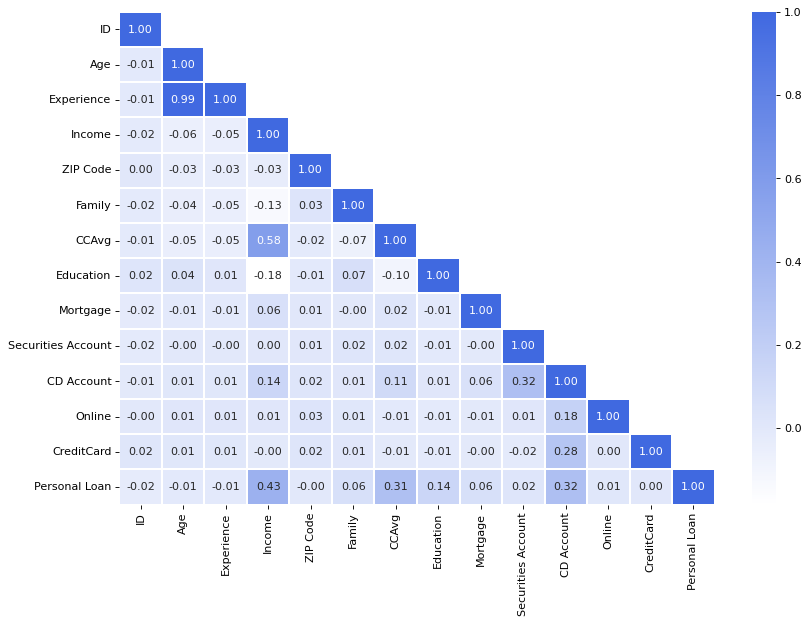

In [4]:
# Calculation of the Spearman correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

In [5]:
df.drop('ID', axis=1, inplace=True) 

In [6]:
# Define a colormap
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

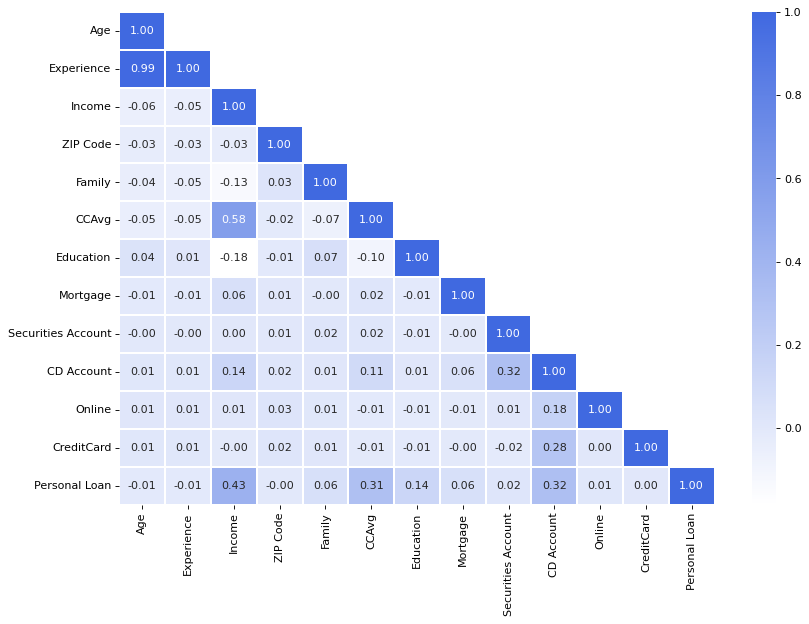

In [7]:
# Calculation of the Spearman correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* __Personal Loan__ is highly correlated with __Income, CD_Account, CCAvg__.
* __Experience__ is highly correlated with __Age__. (ρ = 0.99)
* __CCAvg__ is correlated with __Income__ to a good extent. (ρ = 0.58)

# Data preprocessing

<h3 align="left"><font color='midnightblue'>I) ZIP Code Noise Treatment:</font></h3>

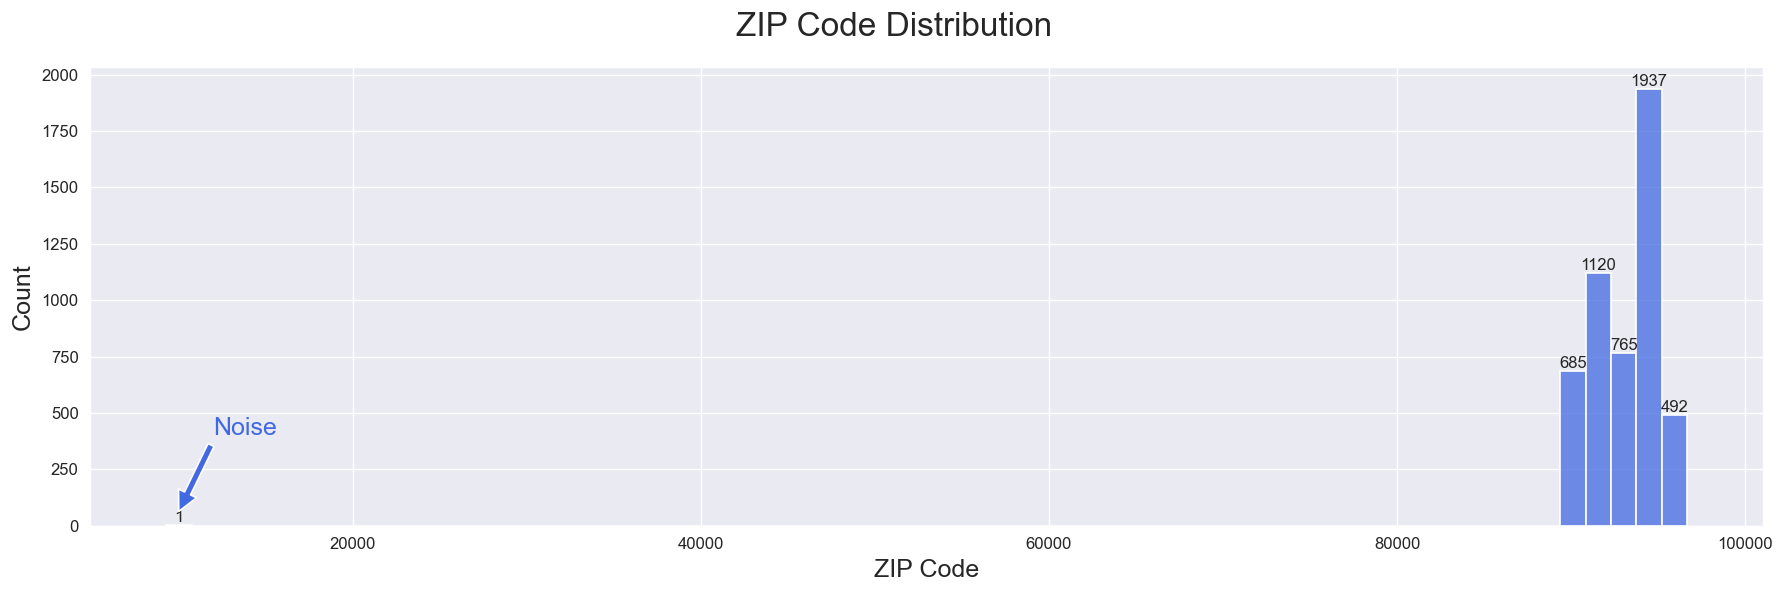

In [9]:
# Set the style of the graph
sns.set_style('darkgrid')
color = 'royalblue'

# Plot histogram
plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='ZIP Code', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)

plt.annotate('Noise', xy=(10000,60), xytext=(12000,400), color=color, fontsize=15, 
             arrowprops=dict(facecolor=color, shrink=0.01))
plt.xlabel('ZIP Code', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('ZIP Code Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [10]:
df[df['ZIP Code']<20000]

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
384,51,25,21,9307,4,0.6,3,0,0,0,0,1,1


In [11]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

<h3 align="left"><font color='midnightblue'>II) Experience Noise Treatment:</font></h3>

In [12]:
df[df['Experience']<0]['Experience'].count()

52

In [13]:
df[df['Experience']<0]['Experience'].count()

52

In [14]:
df['Experience'] = df['Experience'].apply(abs)

<h3 align="left"><font color='midnightblue'>III) Outlier Treatment</font></h3>

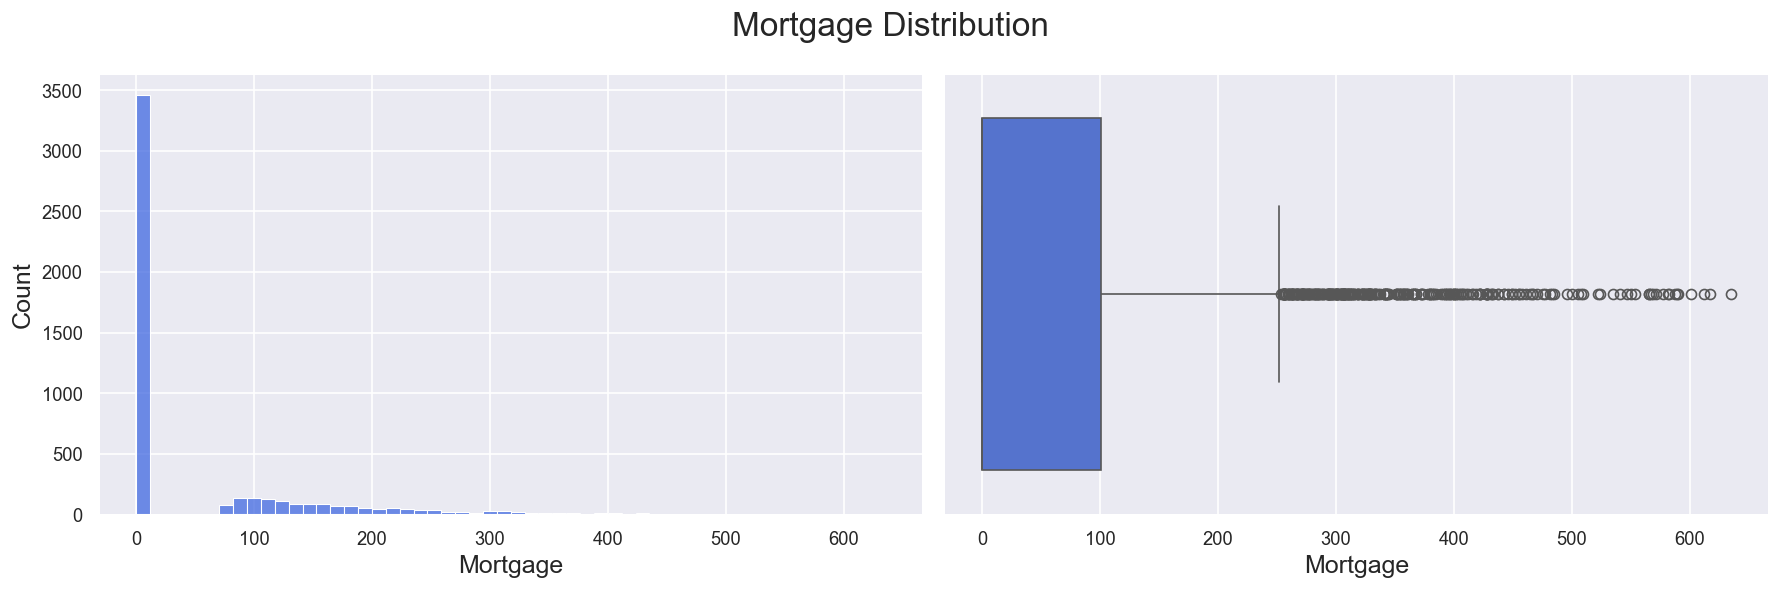

In [15]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='royalblue', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='royalblue', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

The __Z-score__ method for outlier detection is a statistical technique used to detect outliers from data sets by calculating how many standard deviations away from the mean each data point is. A data point with a Z score of more than 3 standard deviation away from the mean is considered an outlier. We use the __scipy.stats__ module to perform the zscore technique:

In [16]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

In [17]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

<h3 align="left"><font color='midnightblue'>V) Missing Value Treatment:</font></h3>

In [18]:
df.isnull().sum().sum()

0

<h3 align="left"><font color='midnightblue'>VI) Duplicate Value Treatment:</font></h3>

In [19]:
df[df.duplicated(keep=False)].sum().sum()

0.0

<h3 align="left"><font color='midnightblue'>VII) Feature Transformation</font></h3>

In [20]:
df['CCAvg'] = df['CCAvg']*12

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894 entries, 0 to 4893
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 4894 non-null   int64  
 1   Experience          4894 non-null   int64  
 2   Income              4894 non-null   int64  
 3   ZIP Code            4894 non-null   int64  
 4   Family              4894 non-null   int64  
 5   CCAvg               4894 non-null   float64
 6   Education           4894 non-null   int64  
 7   Mortgage            4894 non-null   int64  
 8   Personal Loan       4894 non-null   int64  
 9   Securities Account  4894 non-null   int64  
 10  CD Account          4894 non-null   int64  
 11  Online              4894 non-null   int64  
 12  CreditCard          4894 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 497.2 KB


# Data Analysis

<h3 align="left"><font color='midnightblue'>I) Categorical vs Target Variable</font></h3>

In [22]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

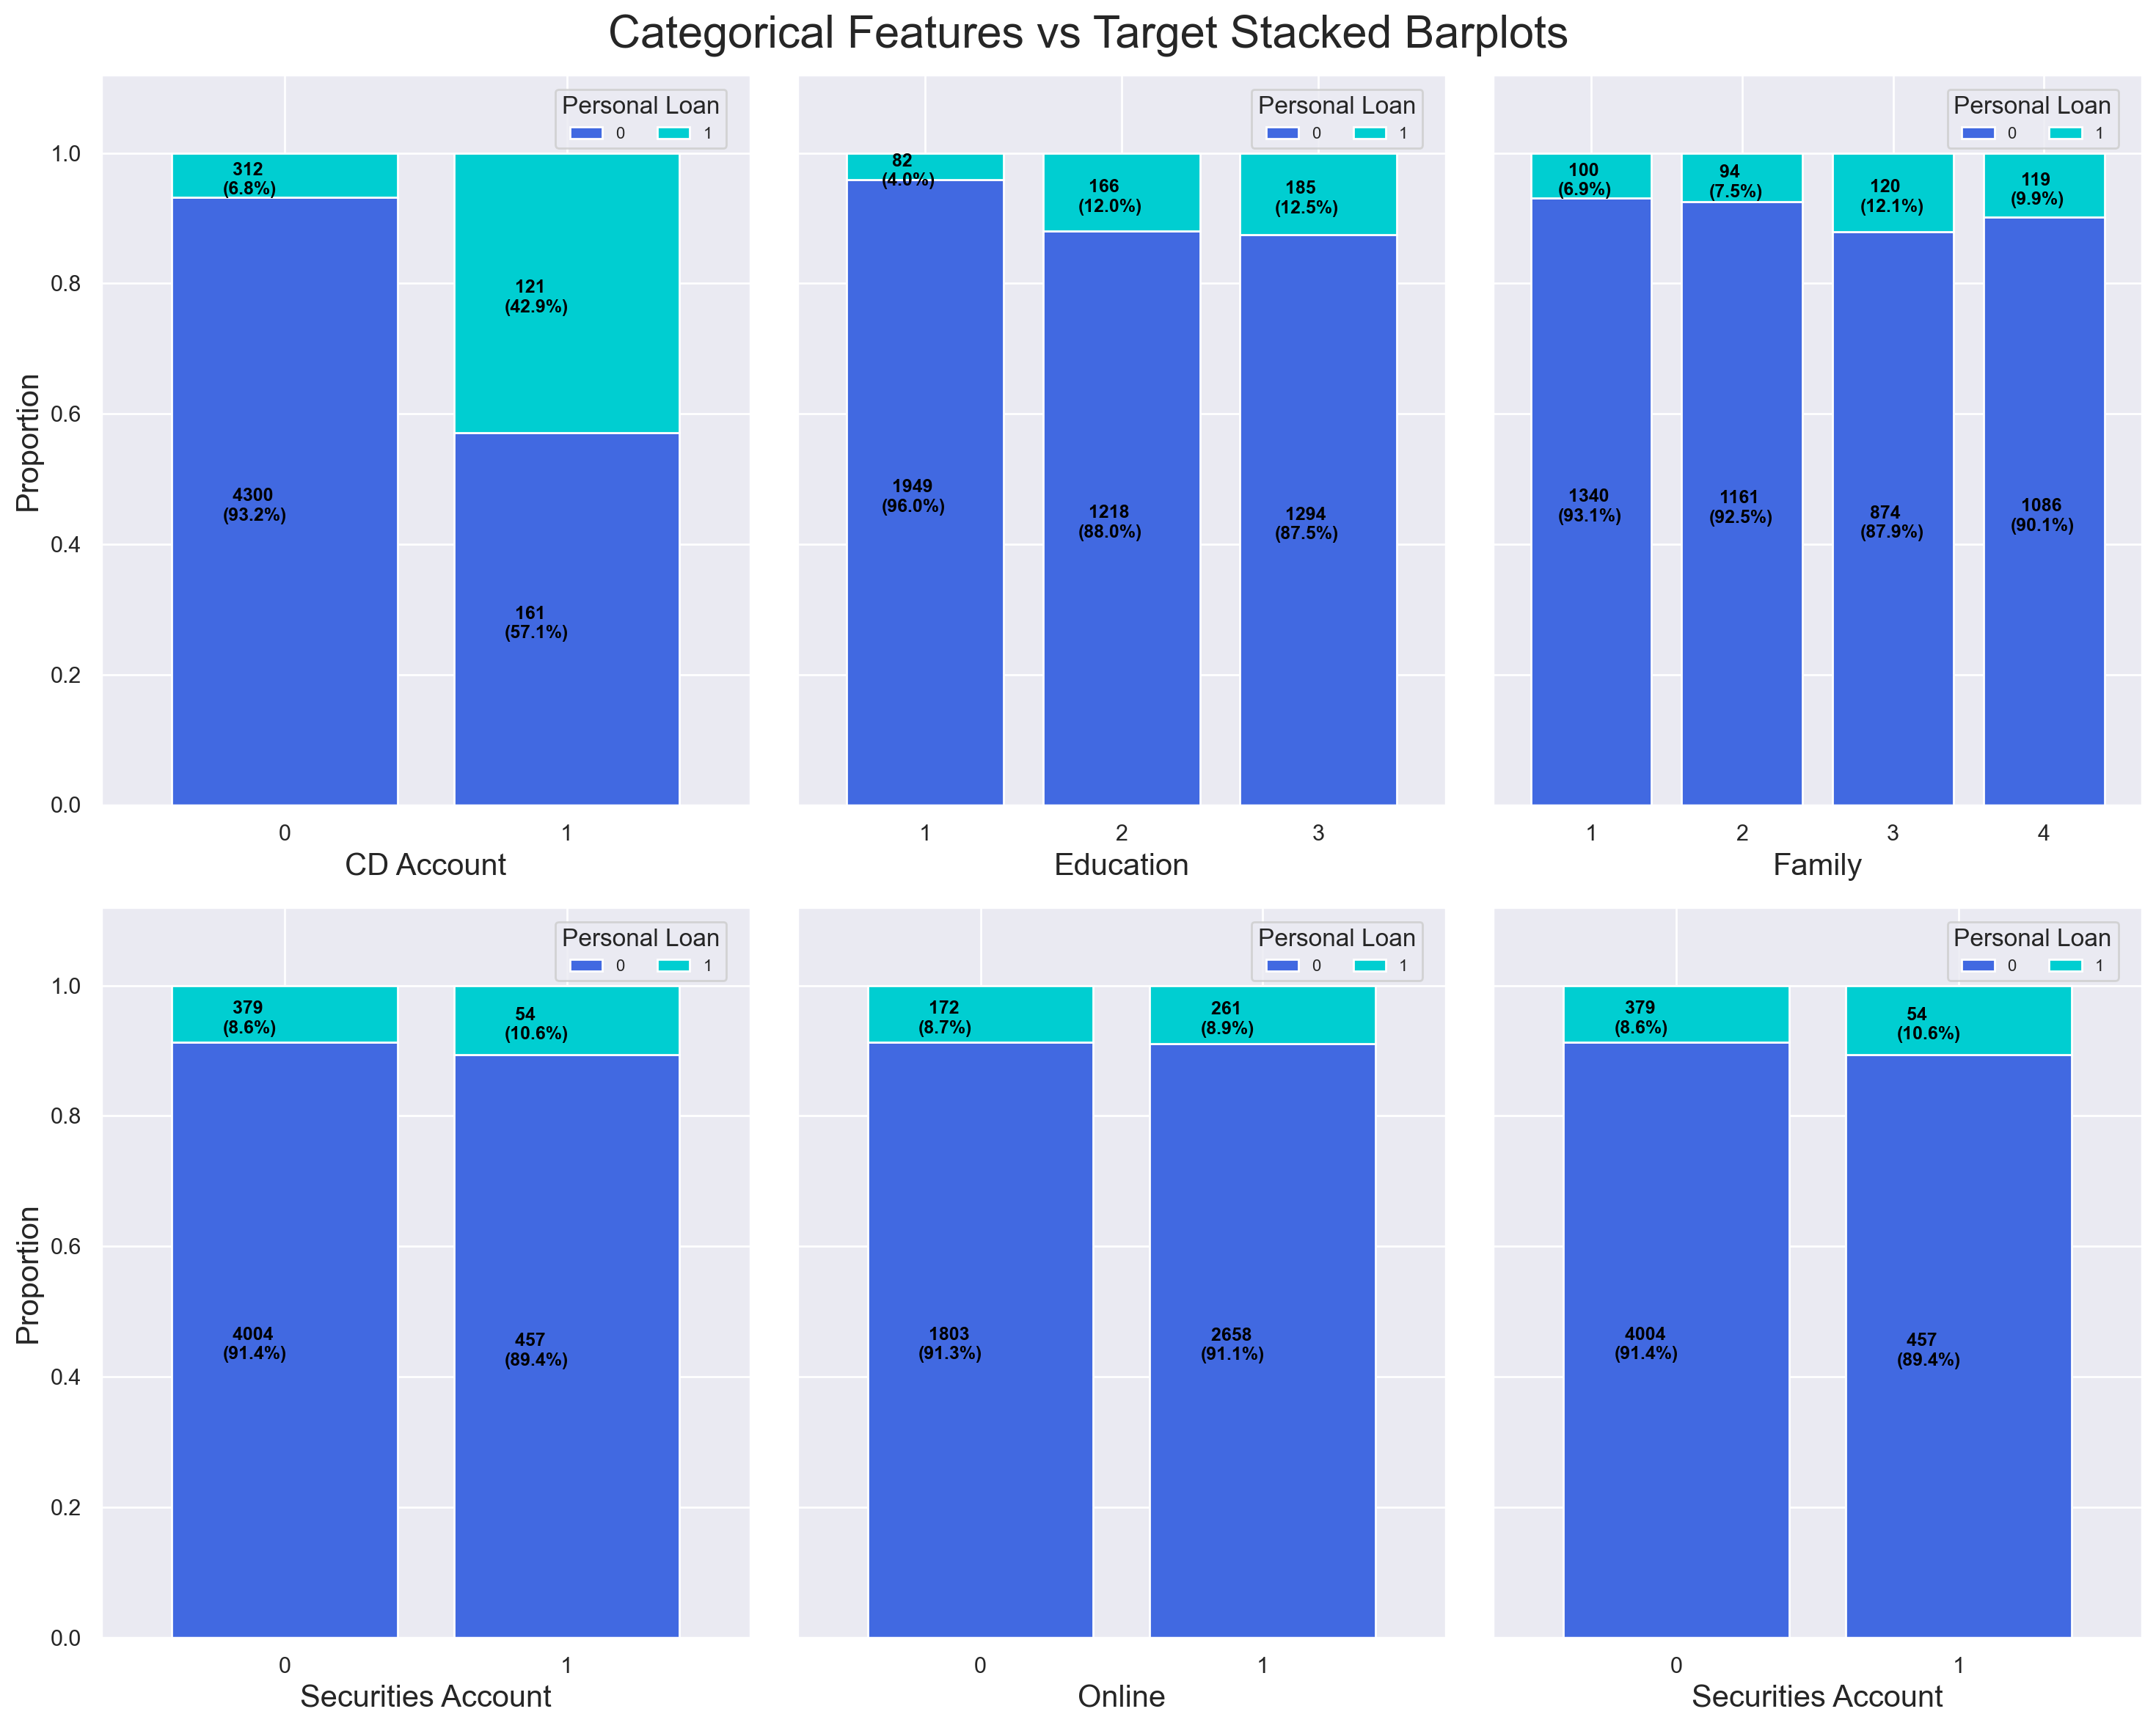

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

* Customers with higher levels of education are more likely to buy personal loans.

* The number of family members has no significant effect on the probability of buying personal loans.

* Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

* The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

* The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

<h3 align="left"><font color='midnightblue'>II) Numerical vs Target Variable</font></h3>

In [24]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

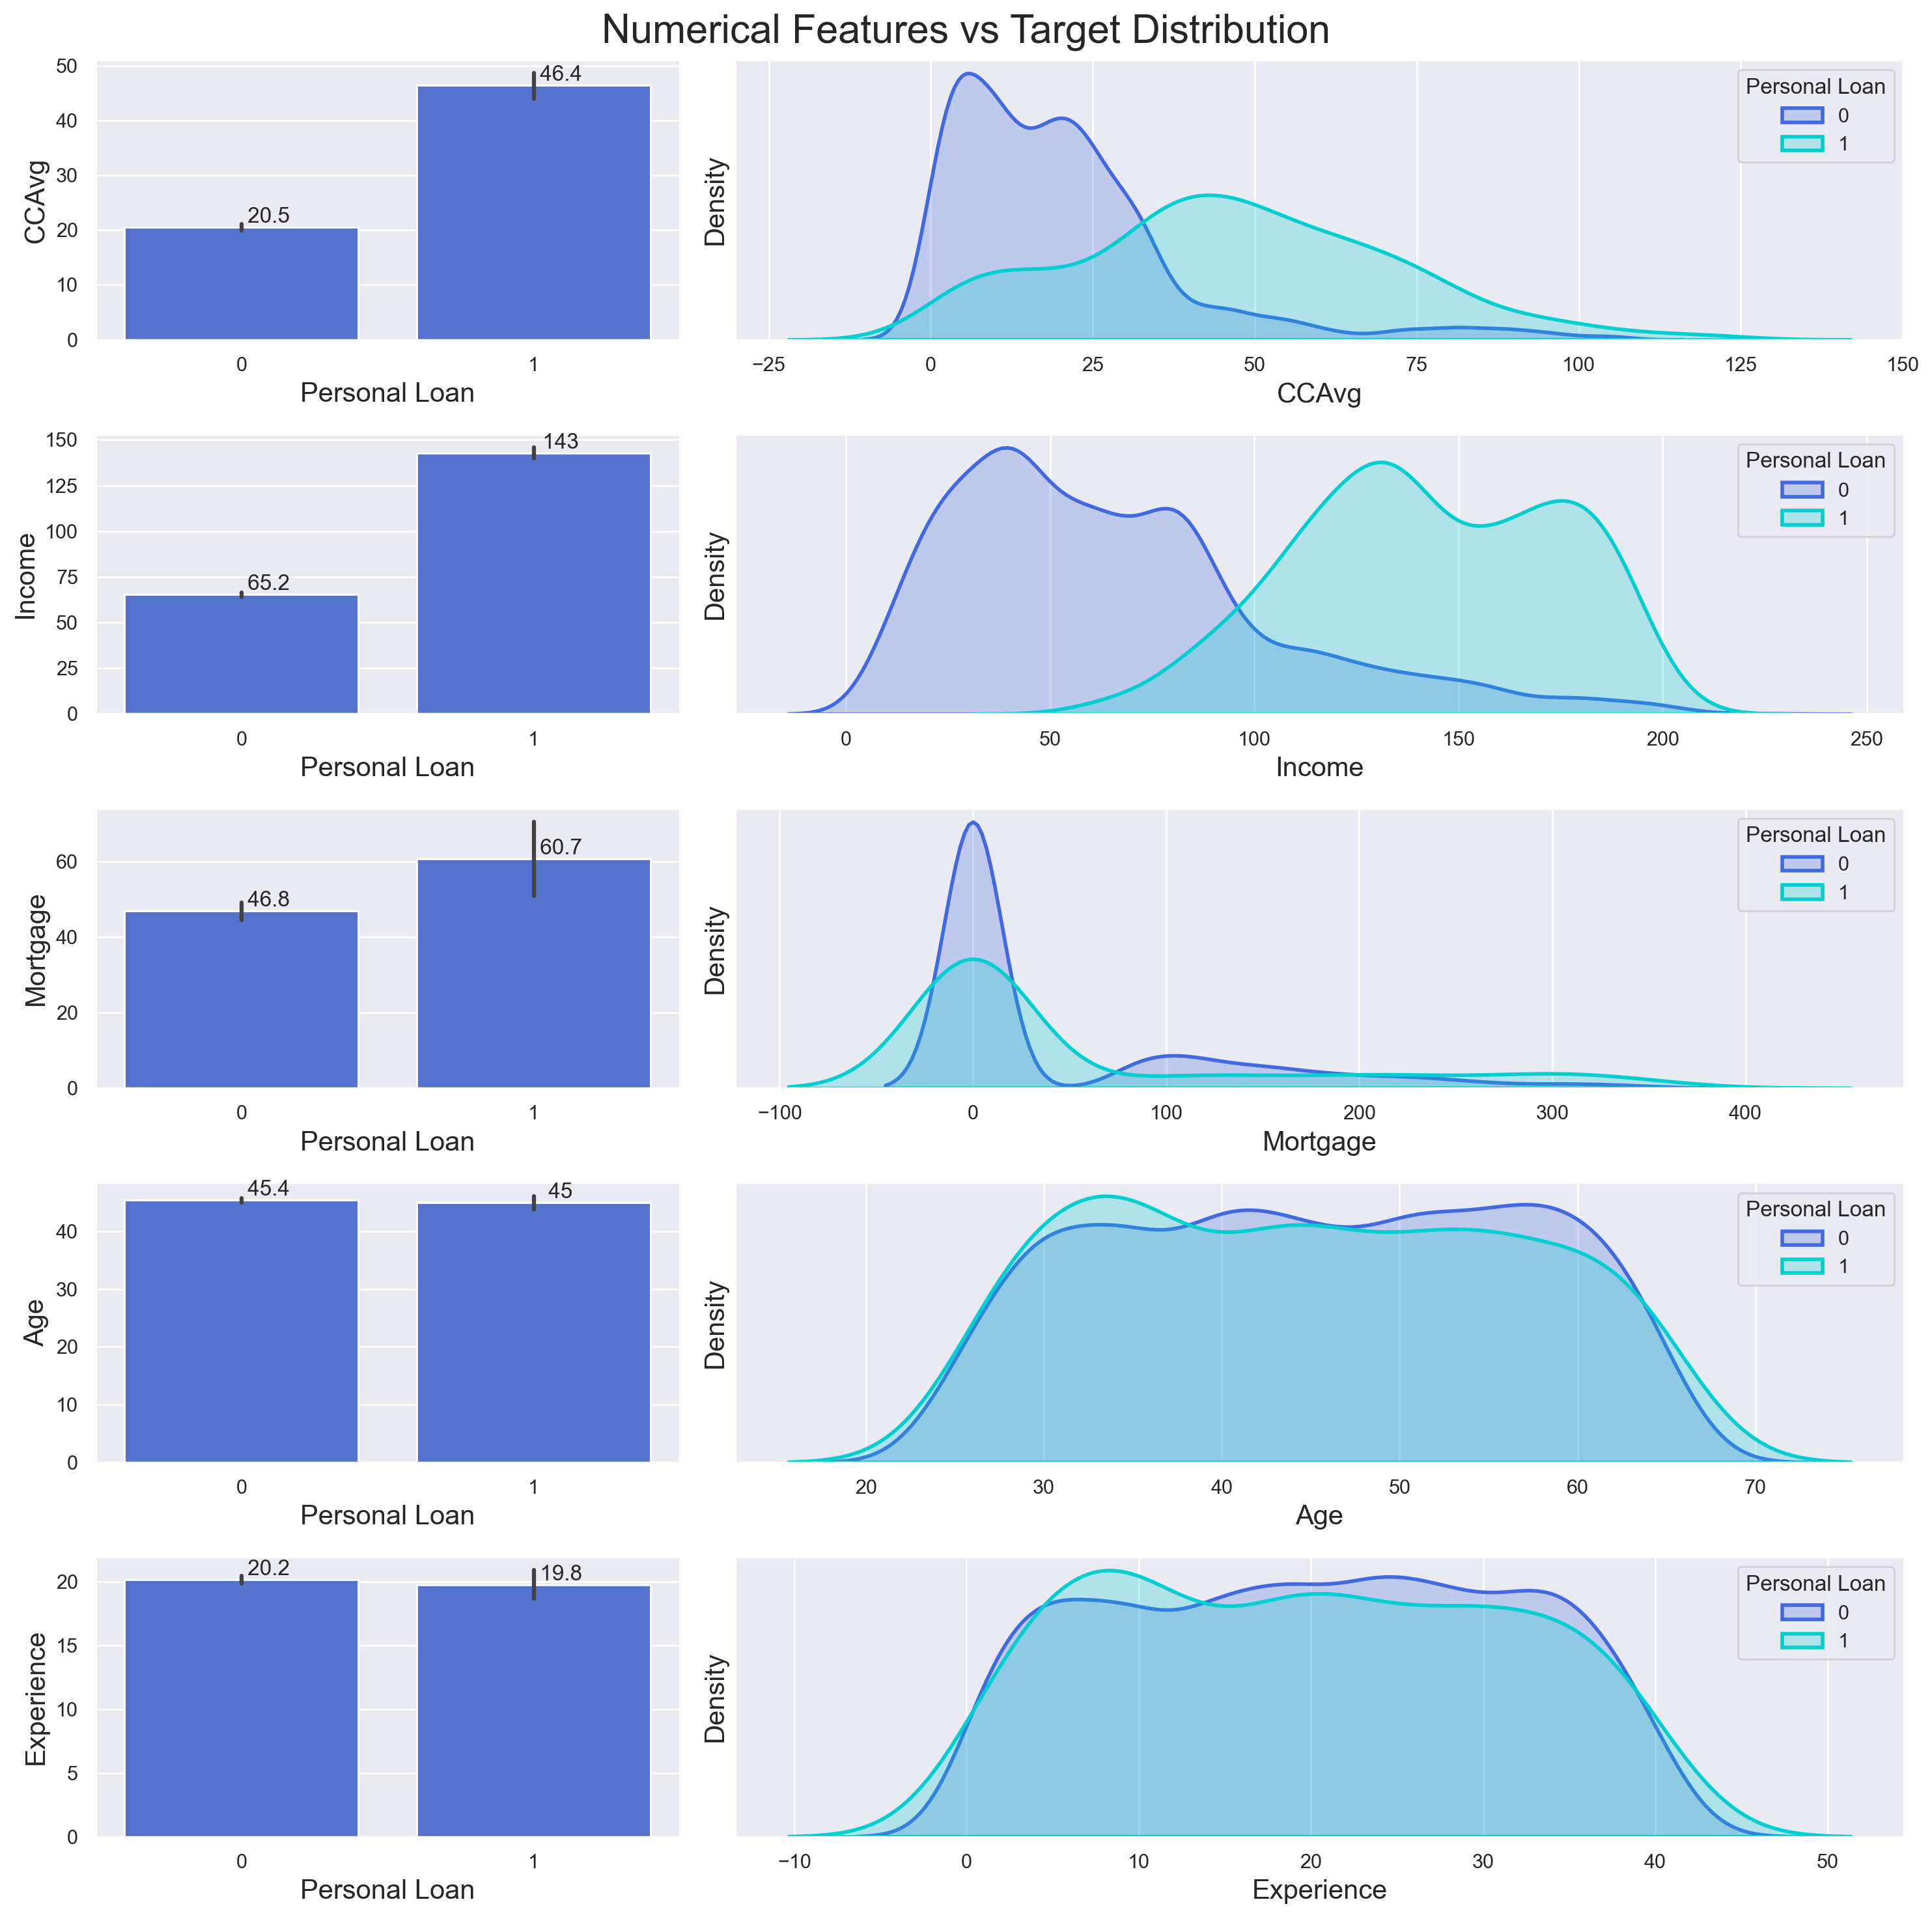

In [25]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* Customers who spend more on credit cards are more likely to take out personal loans.

* Customers with high incomes are more likely to purchase a personal loan.

* Customers with a high mortgage value are more likely to purchase personal loans.

* It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

* The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

>Therefore, we remove Experience because it doesn't provide any more information than Age:

In [26]:
df.drop('Experience', axis=1, inplace=True)

# Train Test Split

In [27]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

____
<h2 align="left"><font color='midnightblue'>Imbalanced dataset:</font></h2>

Imbalanced dataset is a dataset where the classes are not balanced or equal. This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others. 

As we saw in the 3d step, the dataset we are working on is an imbalanced dataset. Let's check it again:

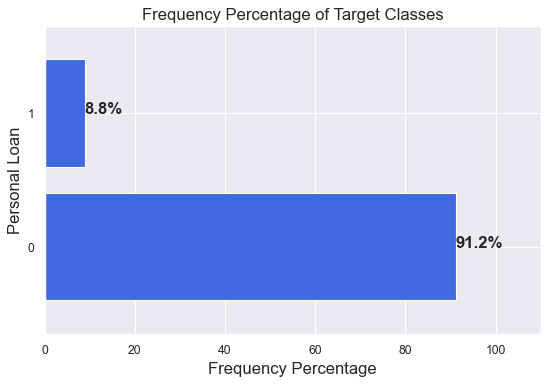

In [28]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

As can be seen, __the dataset we are working on is imbalanced.__

____
<h2 align="left"><font color='midnightblue'>Techniques to Handle Imbalanced Dataset:</font></h2>

<h3 align="left"><font color='royalblue'>1. The approach to train test split:</font></h3>

The approach to train test split when dealing with __imbalanced datasets__ is to use __stratification__. Stratification is an important step in splitting imbalanced datasets into training and test sets. Stratification ensures that the proportion of each class remains the same across both the training and test sets. This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets:

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [30]:
print(X_train, X_test, y_train, y_test)

      Age  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
1372   58      75     92121       1  16.80          3         0   
1662   45     140     91024       2  91.20          1       132   
4776   43      73     94301       3  27.96          1         0   
2791   49      79     94025       4  43.20          3       212   
2174   65      80     94105       1   9.60          3         0   
...   ...     ...       ...     ...    ...        ...       ...   
6      53      72     91711       2  18.00          2         0   
3075   26      30     94024       4  15.60          3         0   
1807   43      65     93065       2  26.40          3         0   
1745   52      19     90650       2   8.40          2         0   
4125   52      43     94005       4   2.40          2         0   

      Securities Account  CD Account  Online  CreditCard  
1372                   0           0       1           0  
1662                   0           0       0           0  
4776              

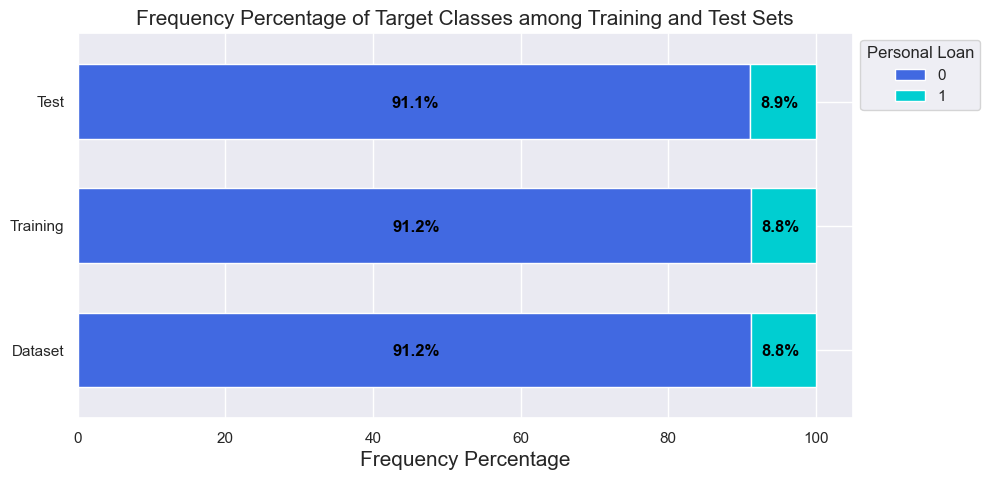

In [31]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            

<h3 align="left"><font color='royalblue'>2. The approach for model evaluation:</font></h3>

The approach for __model evaluation__ when dealing with __imbalanced datasets__ is to use appropriate metrics including __recall, precision, F1 score and AUC(area under curve)__ that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.

* Recall is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential loan customers.

* Precision is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because it means that the model is not identifying many non-loan customers as potential loan customers.

* F1-score is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.

__For this project, both recall and precision for class '1' are important metrics, so f1-score for class '1' should be considered as the most important metric. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision).__

<h3 align="left"><font color='royalblue'>3. Approaches for model building:</font></h3>

> <h3 align="left"><font color='midnightblue'>I) Data-based approaches:</font></h3>
>
>* __Random undersampling__: 
>    * __Cons__: Information loss 
>
>
>* __Random oversampling__: 
>    * __Cons__: Overfitting
> 
>
>* __SMOTE__: SMOTE (Synthetic Minority Oversampling Technique) 
>
>    * __Cons__: Since SMOTE randomly creates rows of new data, the newly created synthetic samples lack real value information, thus leading to a potential decrease in accuracy overall. In addition, if there are natural boundaries between classes such as overlapping classes, additional outliers may be created due to the artificial creation of data points through SMOTE.

> <h3 align="left"><font color='midnightblue'>II) Model-based approaches:</font></h3>
>
> * __Penalize Algorithms__: Penalize algorithms by giving more weight to a specific classification label, making correct classification of the minority class more important than correct classification of the majority class during optimisation process.
>
>
> * __Use Tree-Based Algorithms__: Tree-based algorithms like Random Forest, Extra Trees Classifiers and XGBoost can naturally handle imbalanced data because they make decisions based on a majority vote among randomized decision trees and do not require balancing classes before training.


Considering the disadvantages of data-based methods, we will just implement __model-based approaches__.

# Feature Selection

We use __Drop-column Feature Importance__ method as it is actually __the most accurate way__ to calculate the feature importances.

__Note__: Drop-column method does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for __a particular model__. 

In [34]:
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

In [35]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()

    
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df                  

In [36]:
def drop_column_importance_plot(model, X_train, y_train):
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

# Model Evaluation Metrics

In [37]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [38]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

In [39]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [62]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

# Models Training

<a id="import"></a>
# 1: Logistic Regression

In [42]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [43]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [44]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,20)]

# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'penalty':['none'], 
               'class_weight':class_weights}, 
              
              {'solver':['lbfgs', 'newton-cg', 'sag'], 
               'penalty':['l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['liblinear', 'saga'], 
               'penalty': ['l1', 'l2'], 
               'C': np.logspace(-5, 5, 10), 
               'class_weight':class_weights},
              
              {'solver':['saga'], 
               'penalty':['elasticnet'], 
               'C': np.logspace(-5, 5, 10),
               'l1_ratio': np.arange(0,1.1,0.1), 
               'class_weight':class_weights}]    

In [45]:
logreg_opt = LogisticRegression(
    C=3.593813663804626,
    class_weight={0: 0.4474736842105263, 1: 0.5525263157894738},
    l1_ratio=0.2,
    penalty='elasticnet',
    solver='saga'
)

In [46]:
logreg_opt.fit(X_train, y_train)


LogisticRegression(C=3.593813663804626,
                   class_weight={0: 0.4474736842105263, 1: 0.5525263157894738},
                   l1_ratio=0.2, penalty='elasticnet', solver='saga')

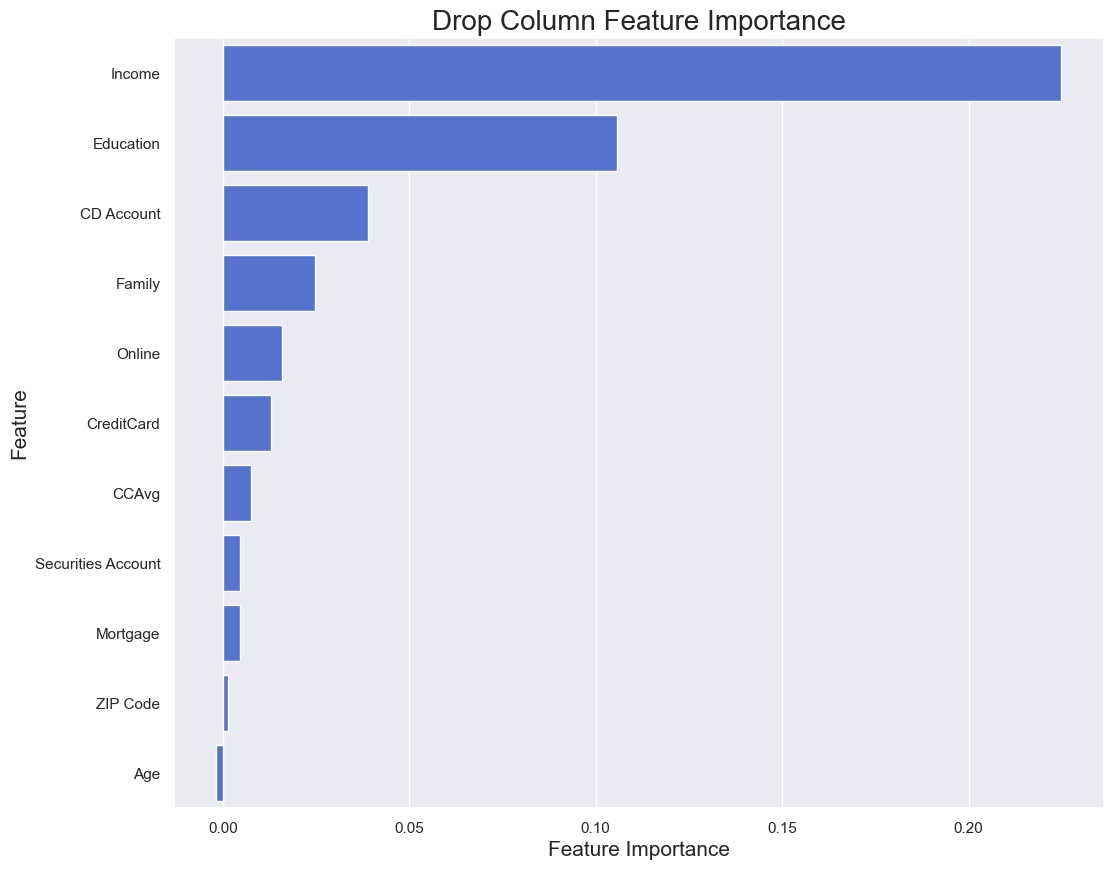

In [47]:
drop_column_importance_plot(logreg_opt, X_train, y_train)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3569
           1       0.81      0.65      0.72       346

    accuracy                           0.96      3915
   macro avg       0.89      0.82      0.85      3915
weighted avg       0.95      0.96      0.95      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       892
           1       0.72      0.67      0.69        87

    accuracy                           0.95       979
   macro avg       0.85      0.82      0.83       979
weighted avg       0.95      0.95      0.95       979



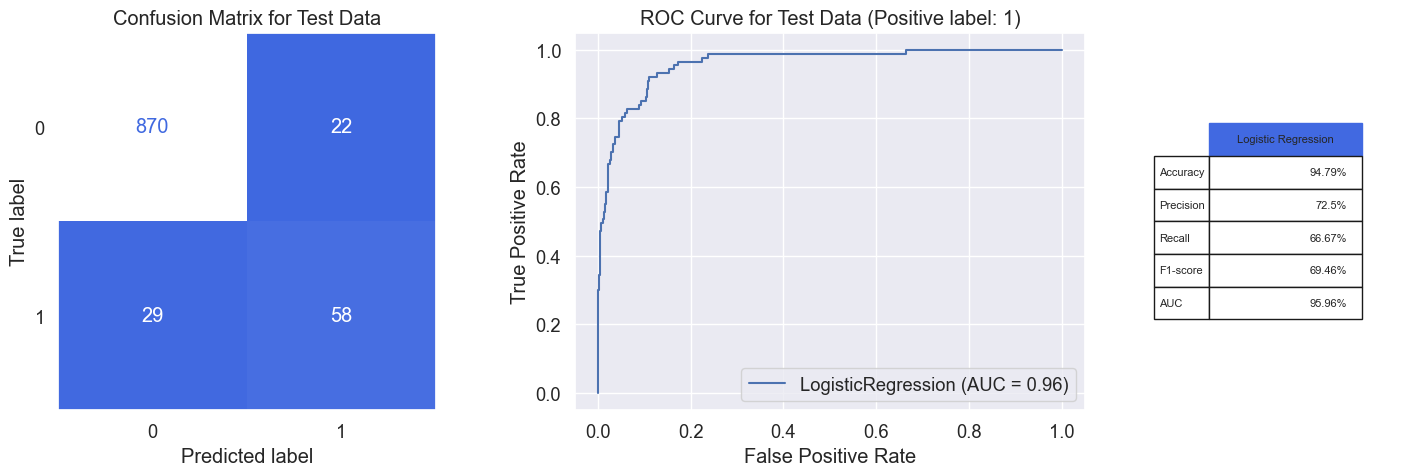

In [48]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

In [49]:
# Save the final performance of Logistic Regression classifier
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')

# KNN Algorithm

In [50]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [51]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [56]:
# Define hyperparameters grid to search
param_grid = [{'n_neighbors': np.arange(2, 30), 'metric': ['euclidean','manhattan'], 'weights': ['uniform']},
              {'n_neighbors': np.arange(2, 30), 'metric': ['minkowski'], 'p': [3,4,5], 'weights': ['uniform']}]

In [66]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
    This function optimize the hyperparameters for a classifier by searching over a specified hyperparameter grid. It uses 
    GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects  
    the combination with the highest f1-score. The function returns the best classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    def f1_metric(knn,y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')
    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring=f1_metric, n_jobs=1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

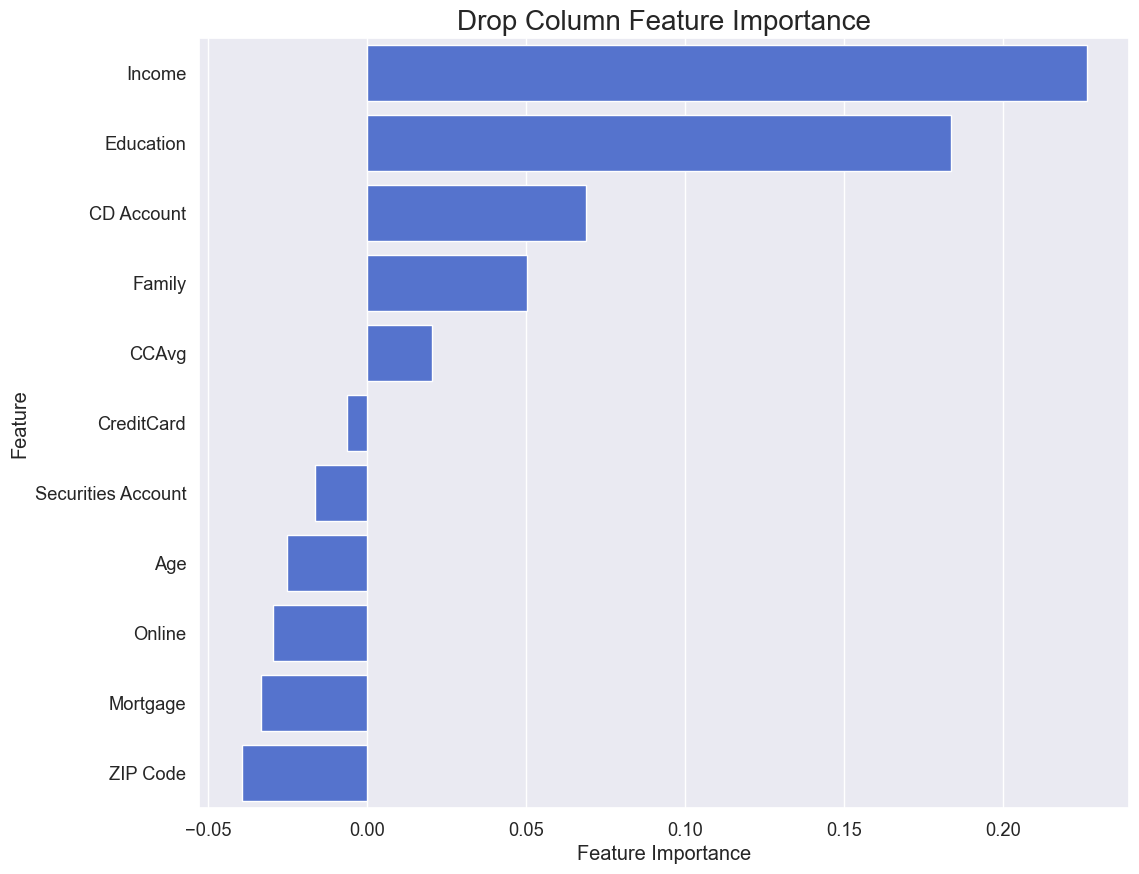

In [59]:
drop_column_importance_plot(knn_opt, X_train, y_train)

In [60]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(knn_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0]['feature']

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [68]:
# Create a KNN classifier object
knn = KNeighborsClassifier()

# Find the best classifier with the optimal hyperparameters
knn_opt = KNeighborsClassifier(metric='minkowski', n_neighbors=3, p=5, weights='uniform')

In [69]:
knn_opt.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, p=5)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.99      0.90      0.94       346

    accuracy                           0.99      3915
   macro avg       0.99      0.95      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.87      0.91        87

    accuracy                           0.98       979
   macro avg       0.97      0.93      0.95       979
weighted avg       0.98      0.98      0.98       979



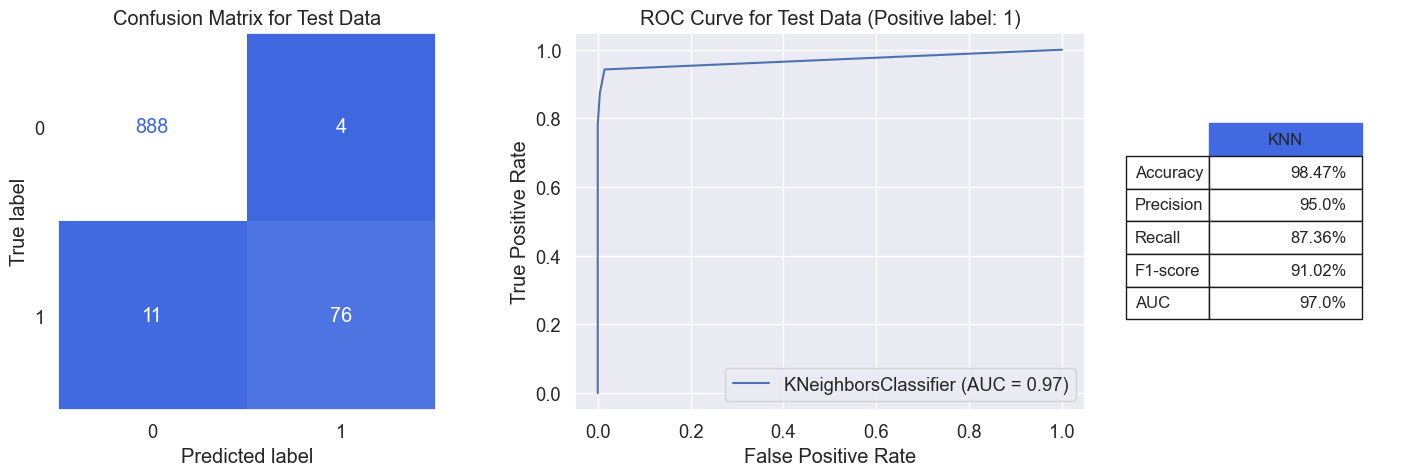

In [70]:
model_evaluation(knn_opt, X_train, X_test, y_train, y_test, 'KNN')

In [71]:
# Save the final performance of KNN classifier
knn_result = metrics_calculator(knn_opt, X_test, y_test, 'K-Nearest Neighbors')

# SVM

In [72]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [73]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [74]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,12)]

# Define the hyperparameter grid to search
param_grid = [{'kernel': ['poly'], 
               'degree': [2,3,4,5], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['rbf','sigmoid'],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights},
                  
              {'kernel': ['linear'],
               'C': [0.01,0.1,1, 10, 100, 1000],
               'class_weight': class_weights}
             ]

In [75]:
# Create SVM classifier with the best hyperparameters
svm_opt = SVC(C=100, class_weight={0: 0.3639090909090909, 1: 0.636090909090909}, gamma=0.01, kernel='rbf', probability=True, random_state=0)

# Fit the classifier to your training data
svm_opt.fit(X_train, y_train)

SVC(C=100, class_weight={0: 0.3639090909090909, 1: 0.636090909090909},
    gamma=0.01, probability=True, random_state=0)

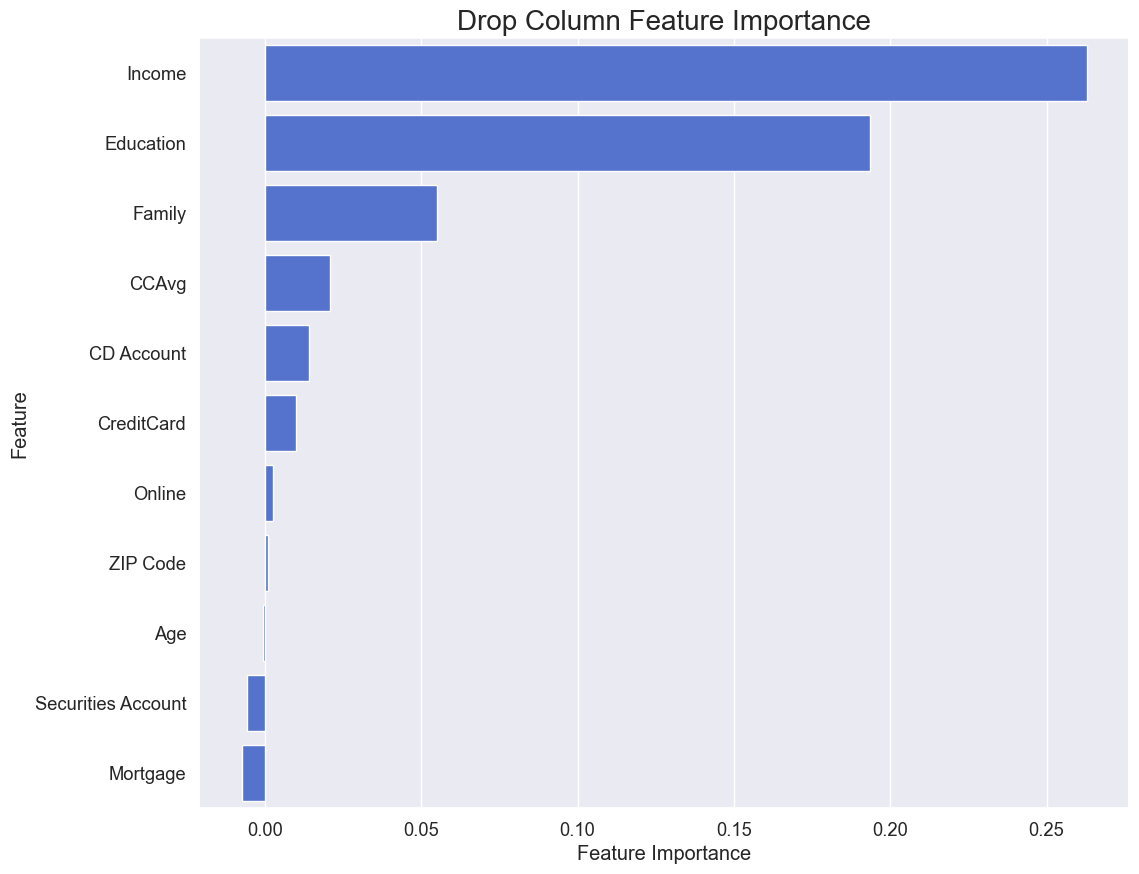

In [76]:
drop_column_importance_plot(svm_opt, X_train, y_train)

In [78]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(svm_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature']  # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [79]:
svm_opt = SVC(C=1000, class_weight={0: 0.4546363636363636, 1: 0.5453636363636364}, gamma=0.1, kernel='rbf', probability=True, random_state=0)

# Fit the classifier to your training data
svm_opt.fit(X_train, y_train)

SVC(C=1000, class_weight={0: 0.4546363636363636, 1: 0.5453636363636364},
    gamma=0.1, probability=True, random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.97      0.91      0.94       346

    accuracy                           0.99      3915
   macro avg       0.98      0.95      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.89      0.92        87

    accuracy                           0.99       979
   macro avg       0.98      0.94      0.96       979
weighted avg       0.99      0.99      0.99       979



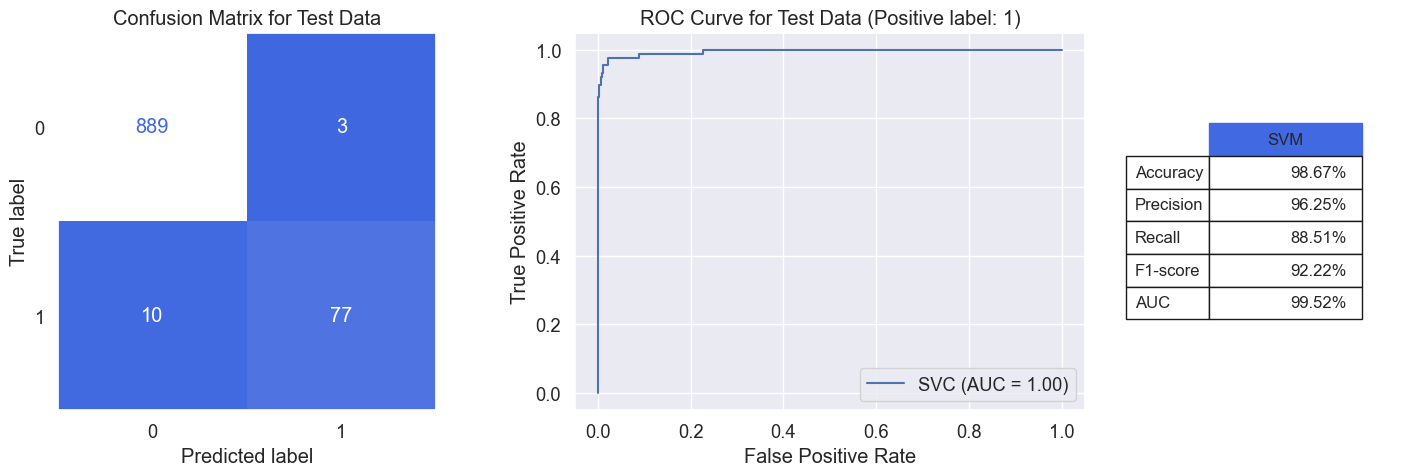

In [80]:
model_evaluation(svm_opt, X_train, X_test, y_train, y_test, 'SVM')

In [81]:
# Save the final performance of SVM classifier
svm_result = metrics_calculator(svm_opt, X_test, y_test, 'SVM')

# Decision Tree

In [82]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]
    
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(1, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2'],
              'class_weight': class_weights} 

In [83]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

dt_opt = DecisionTreeClassifier(
    class_weight={0: 0.6319473684210526, 1: 0.3680526315789474},
    criterion='gini',
    max_depth=5,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=2
)

# Fit the model to the training data
dt_opt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.6319473684210526,
                                     1: 0.3680526315789474},
                       max_depth=5, min_samples_leaf=3)

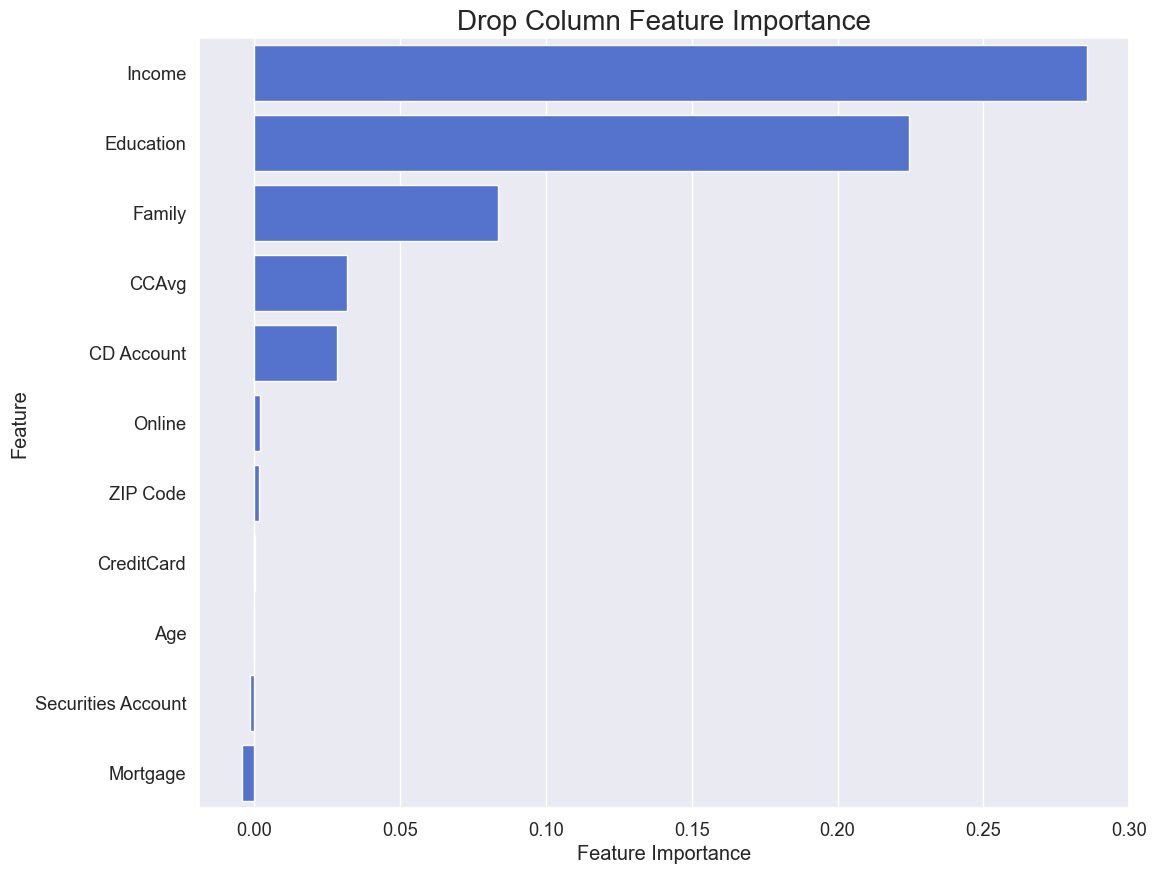

In [84]:
drop_column_importance_plot(dt_opt, X_train, y_train)

In [85]:
# Find Important features with positive feature_importance value
feature_importances = drop_column_importance(dt_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.01]['feature'] # Threshold value of 0.01

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [86]:
dt_opt = DecisionTreeClassifier(
    class_weight={0: 0.5267894736842105, 1: 0.4732105263157895},
    criterion='gini',
    max_depth=9,
    max_features=None,
    min_samples_leaf=6,
    min_samples_split=2
)

# Fit the model to the training data
dt_opt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.5267894736842105,
                                     1: 0.4732105263157895},
                       max_depth=9, min_samples_leaf=6)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.97      0.90      0.93       346

    accuracy                           0.99      3915
   macro avg       0.98      0.95      0.96      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.86      0.91        87

    accuracy                           0.98       979
   macro avg       0.97      0.93      0.95       979
weighted avg       0.98      0.98      0.98       979



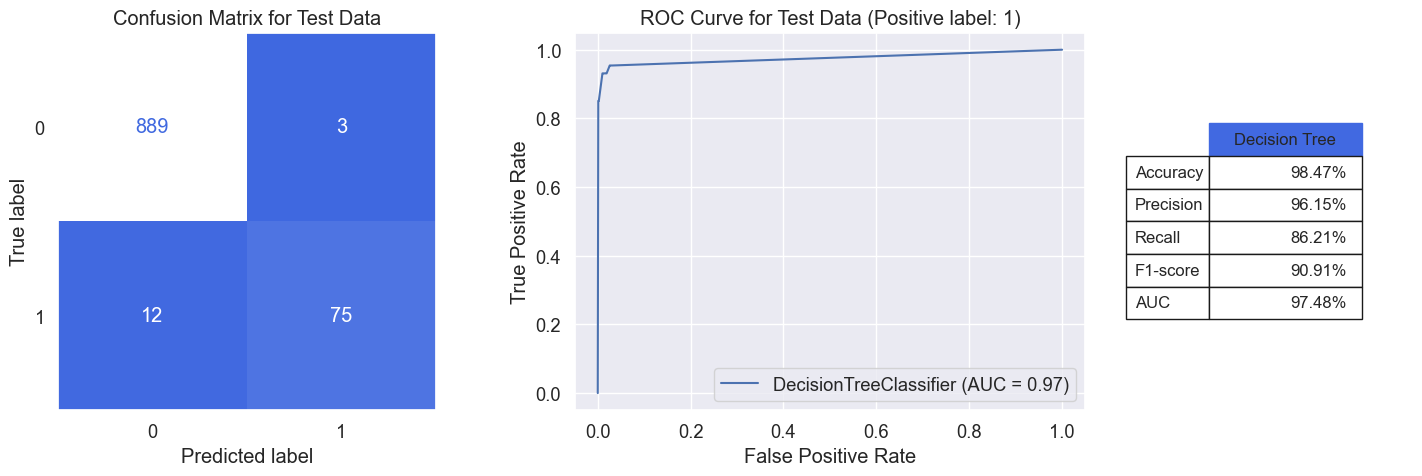

In [87]:
model_evaluation(dt_opt, X_train, X_test, y_train, y_test, 'Decision Tree')

In [88]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_opt, X_test, y_test, 'Decision Tree')

# Random Forest

In [89]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': class_weights
}

In [90]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Define the Random Forest classifier with the provided hyperparameters
rf_opt = RandomForestClassifier(
    class_weight={0: 0.5793684210526315, 1: 0.42063157894736847},
    max_depth=9,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100
)

# Fit the model to the training data
rf_opt.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.5793684210526315,
                                     1: 0.42063157894736847},
                       max_depth=9, min_samples_leaf=2)

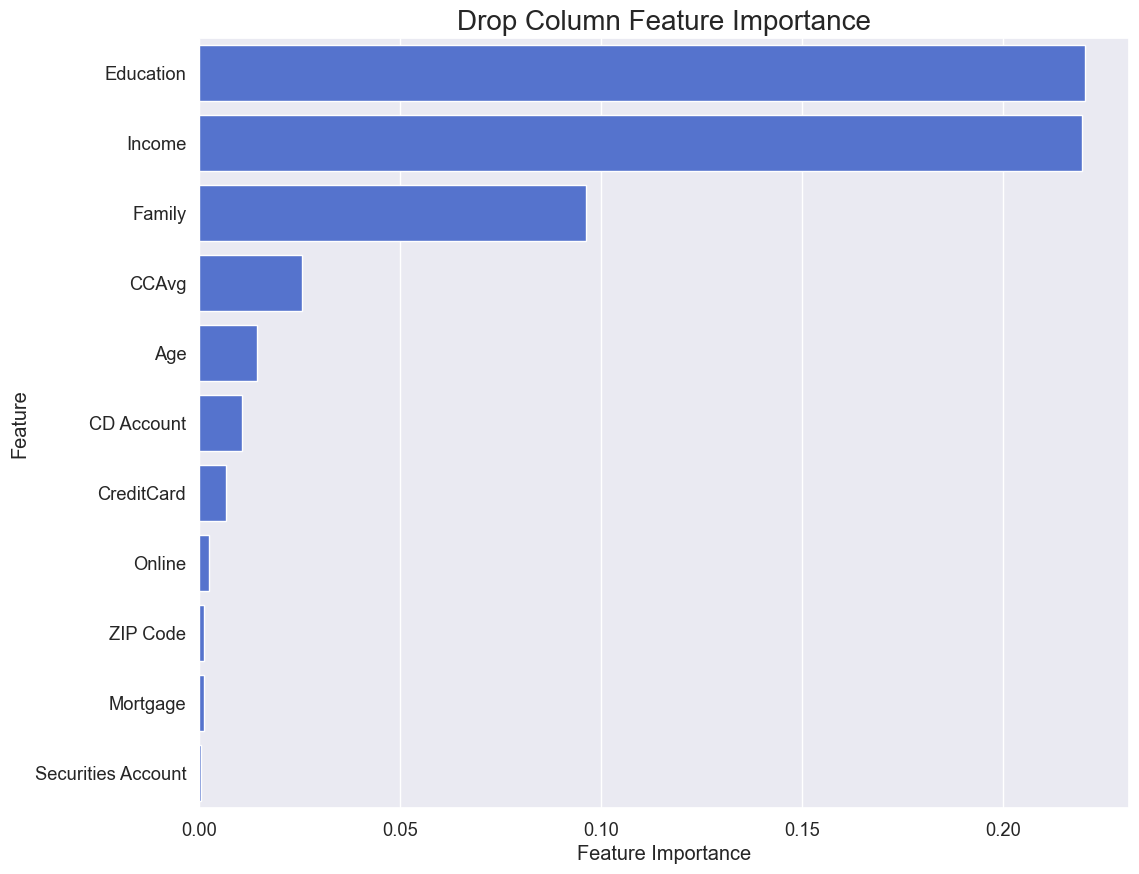

In [91]:
drop_column_importance_plot(rf_opt, X_train, y_train)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3569
           1       1.00      0.91      0.95       346

    accuracy                           0.99      3915
   macro avg       1.00      0.96      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.99      0.85      0.91        87

    accuracy                           0.99       979
   macro avg       0.99      0.92      0.95       979
weighted avg       0.99      0.99      0.99       979



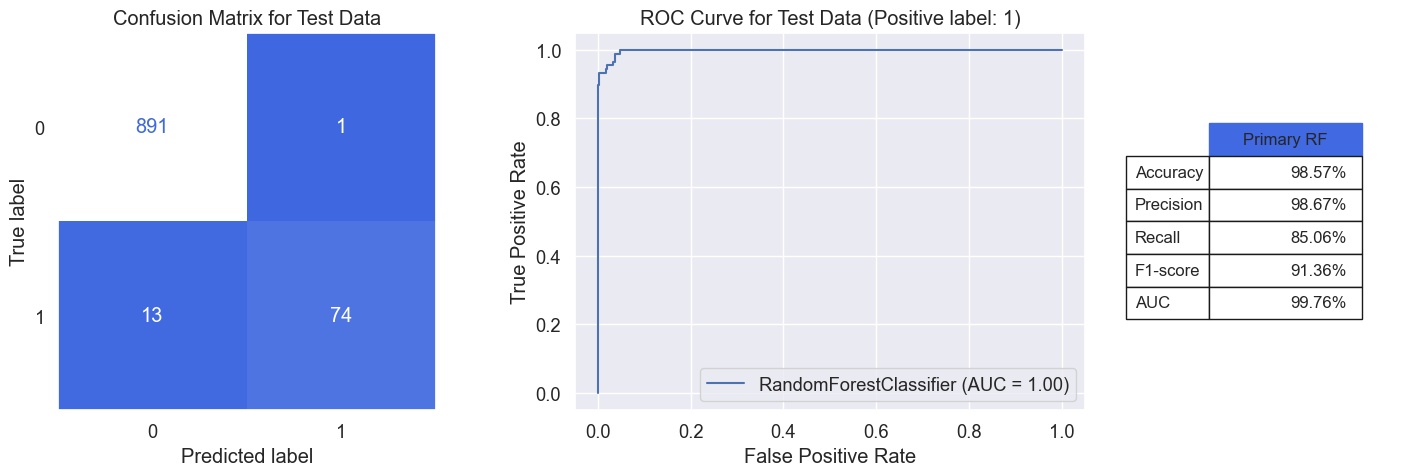

In [92]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')

In [93]:
# Build random forest classifier object considering the obtained optimal values for hyperparameters
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=100, 
                                  max_depth = 9,  min_samples_leaf=6, min_samples_split=2,
                                  class_weight={0: 0.58, 1: 0.42}, random_state=0)
                             
                            
# Train the final Random Forest model
rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.58, 1: 0.42}, max_depth=9,
                       max_features=None, min_samples_leaf=6, random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3569
           1       0.99      0.90      0.94       346

    accuracy                           0.99      3915
   macro avg       0.99      0.95      0.97      3915
weighted avg       0.99      0.99      0.99      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.99      0.90      0.94        87

    accuracy                           0.99       979
   macro avg       0.99      0.95      0.97       979
weighted avg       0.99      0.99      0.99       979



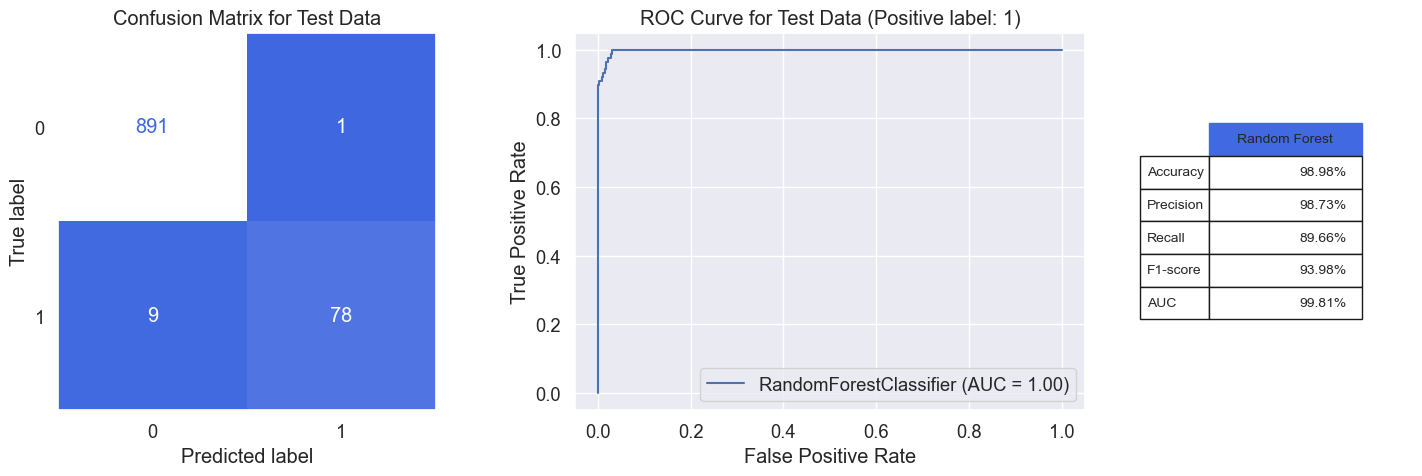

In [94]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')

In [95]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')

# Gradient Boosting

In [97]:
# Define the hyperparameter grid for tuning
gbc_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'learning_rate': [0.3, 0.4, 0.5]
}

In [98]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initialize the Gradient Boosting Classifier
gbc_opt = GradientBoostingClassifier(
    learning_rate=0.4,
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=100,
    subsample=1.0
)

# Fit the model to the training data
gbc_opt.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.4, max_depth=5, min_samples_leaf=4)

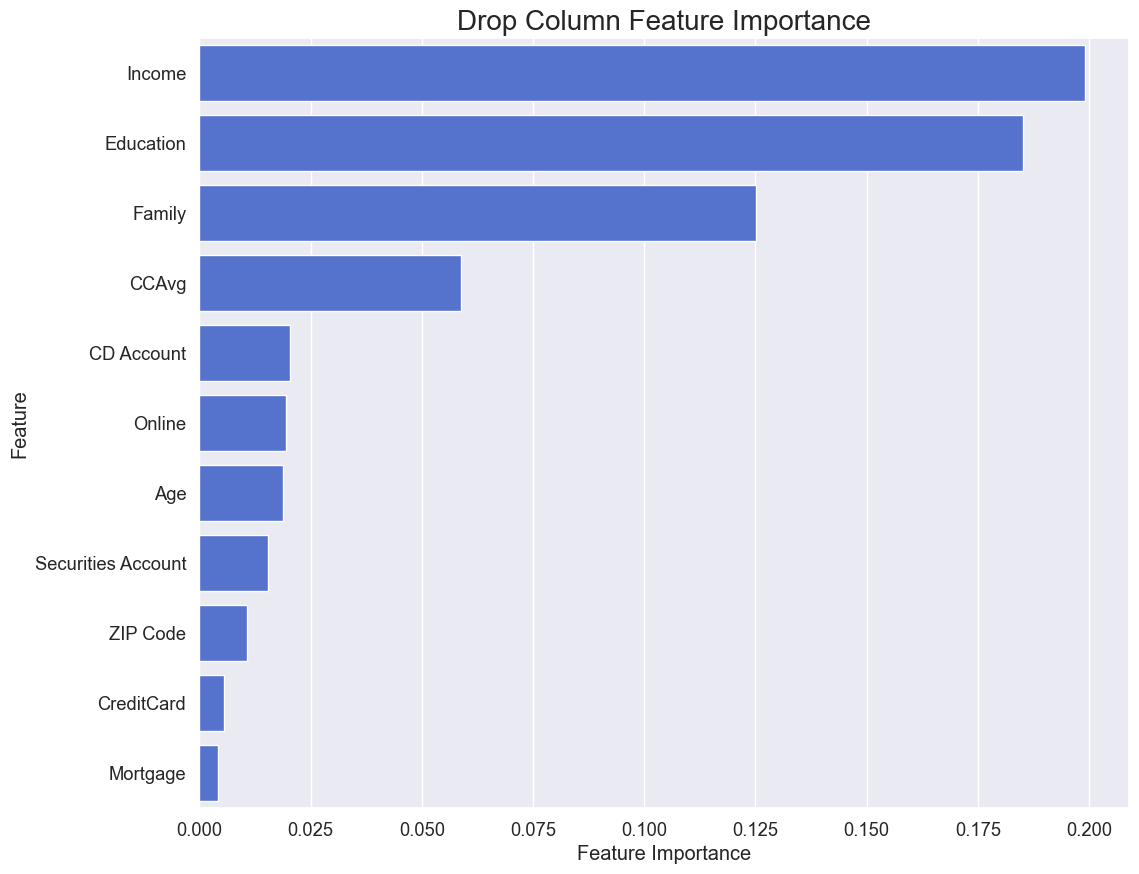

In [99]:
drop_column_importance_plot(gbc_opt, X_train, y_train)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.93      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



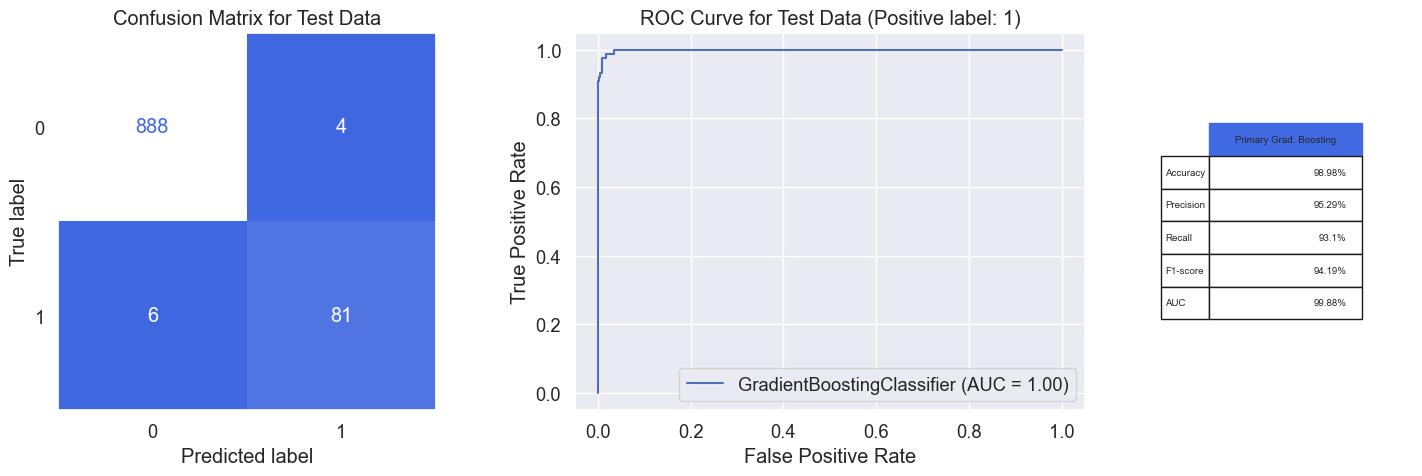

In [100]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary Grad. Boosting')

In [101]:
gb_opt = GradientBoostingClassifier(
    learning_rate=0.4,
    max_depth=5,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=100,
    subsample=1.0,  # Use 'deviance' instead of 'log_loss'
)

# Fit the model to the training data
gb_opt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.4, max_depth=5, min_samples_leaf=4)

In [102]:
gbc_final = GradientBoostingClassifier(max_features=None, criterion='friedman_mse',
                                 learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0,
                                 min_samples_leaf=4, min_samples_split=2, random_state=0)

# Train the final AdaBoost classifier
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                           random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.99      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



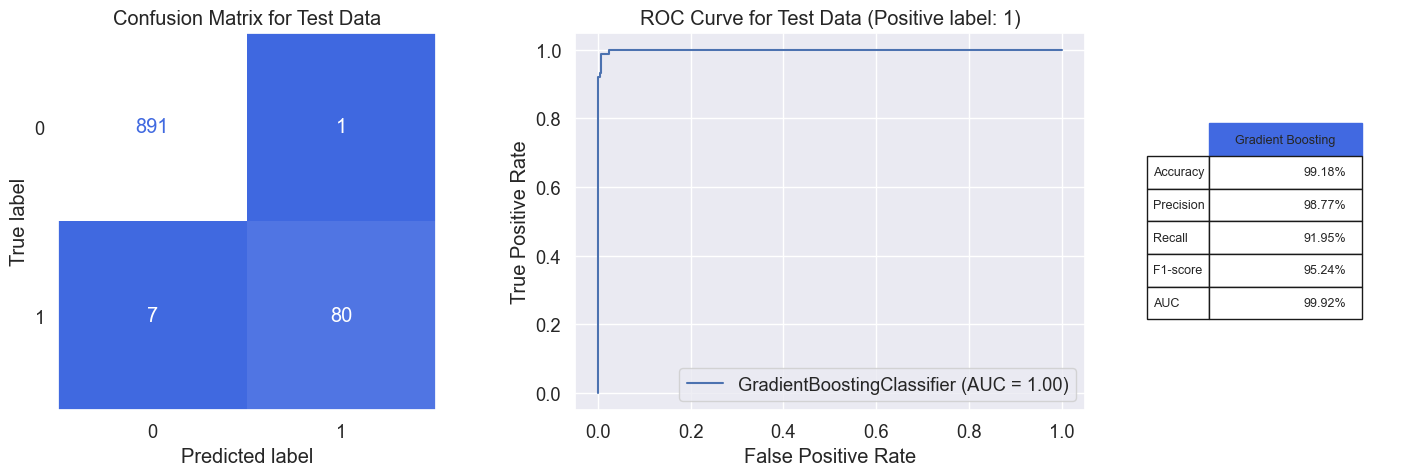

In [103]:
model_evaluation(gbc_final, X_train, X_test, y_train, y_test, 'Gradient Boosting')

In [104]:
# Save the final performance of Gradient Boosting classifier
gbc_result = metrics_calculator(gbc_final, X_test, y_test, 'Gradient Boosting')

# XG Boost

In [105]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [106]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

In [107]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

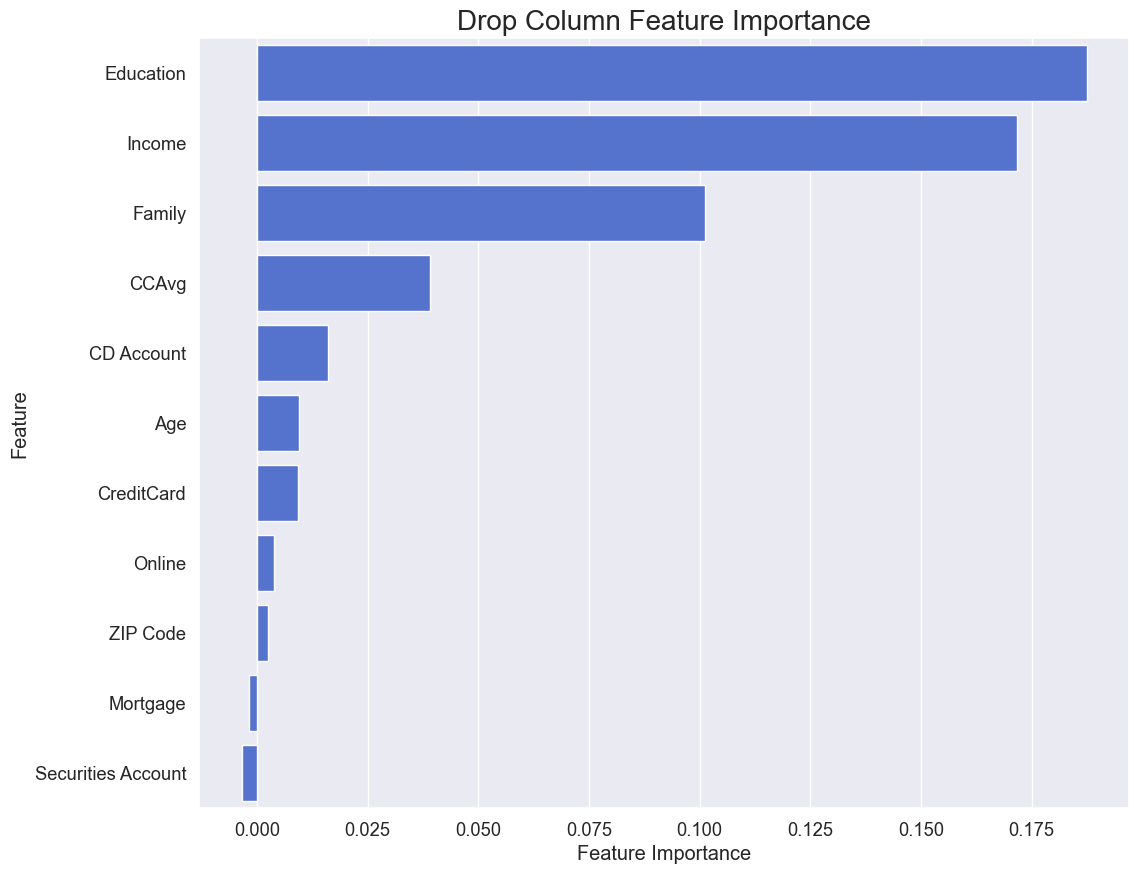

In [108]:
drop_column_importance_plot(xgb_opt, X_train, y_train)

In [109]:
# Find Important features
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

In [110]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.3,
                    n_estimators=200,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logistic',
                    eval_metric='error', 
                    random_state=0)

# Train the XGBoost Classifier
xgb.fit(X_train, y_train)

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [113]:
# Initialize the XGBoost Classifier
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

# Train the XGBoost Classifier
xgb_final.fit(X_train, y_train)

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.99      0.91      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.95      0.97       979
weighted avg       0.99      0.99      0.99       979



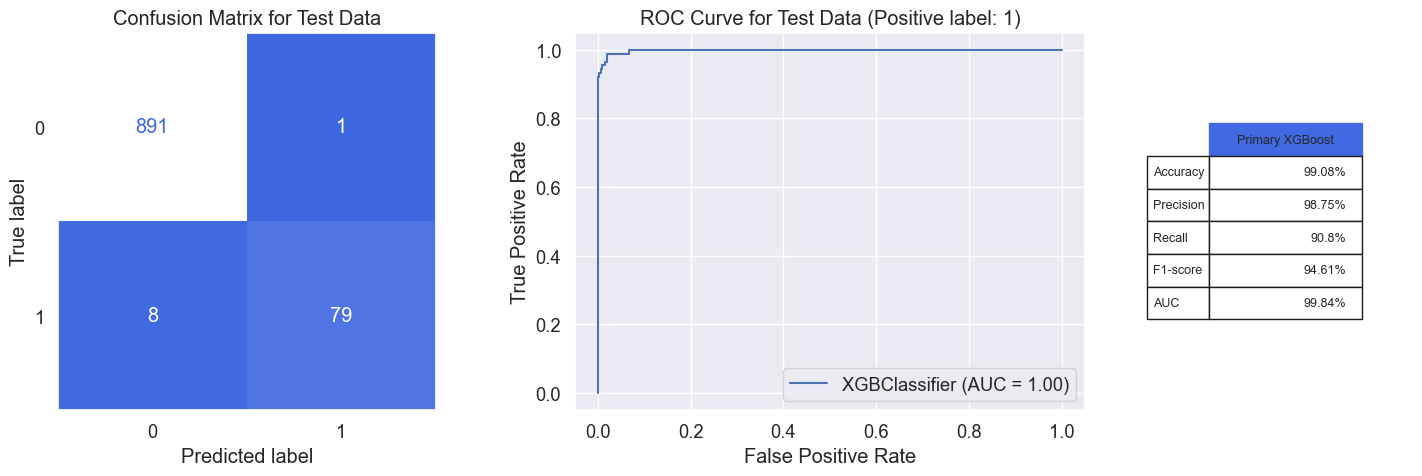

In [114]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

In [115]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Nimisha\anaconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\

In [116]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([logreg_result, knn_result, svm_result, dt_result,
           rf_result, gbc_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

C:\Users\Nimisha\AppData\Local\Temp\ipykernel_17084\1278103875.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')


,Accuracy,Precision,Recall,F1-score,AUC
Gradient Boosting,99.18%,98.77%,91.95%,95.24%,99.92%
XGBoost,99.08%,97.56%,91.95%,94.67%,99.9%
Random Forest,98.98%,98.73%,89.66%,93.98%,99.81%
SVM,98.67%,96.25%,88.51%,92.22%,99.52%
K-Nearest Neighbors,98.47%,95.0%,87.36%,91.02%,97.0%
Decision Tree,98.47%,96.15%,86.21%,90.91%,97.48%
Logistic Regression,94.79%,72.5%,66.67%,69.46%,95.96%


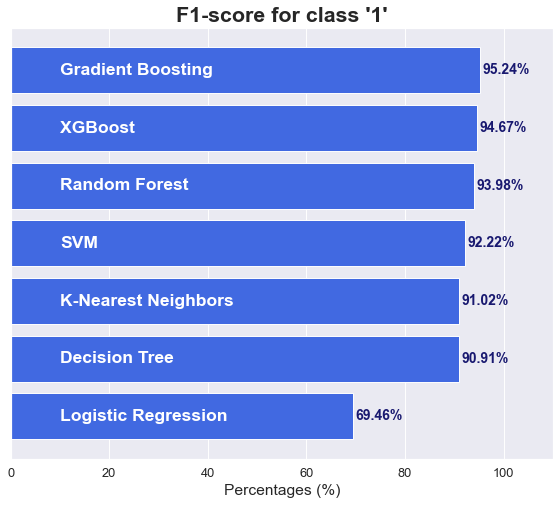

In [117]:
# Prepare values
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [118]:
import pickle
file=open("gb.pkl", 'wb')
pickle.dump(gbc_final, file)